In [172]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from evolution.evaluation.evaluator import EnROADSEvaluator
from experiments.experiment_utils import NNExperimenter, DirectExperimenter
from enroadspy import load_input_specs, id_to_name
from enroadspy.generate_url import open_browser

In [173]:
results_dir = Path("results/all-action-direct-decomplexify")
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
outcome_keys = list(outcomes.keys())
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

399 {'Action magnitude': True, 'Actions taken': True, 'Temperature change from 1850': True} 102 0


In [174]:
input_specs = load_input_specs()

evaluator = EnROADSEvaluator(context, actions, outcomes, n_jobs=1, batch_size=config["batch_size"], device=config["device"])
if len(context) > 0:
    experimenter = NNExperimenter(results_dir)
else:
    experimenter = DirectExperimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [175]:
def get_search_space_size(actions: list[str]):
    input_specs = load_input_specs()
    size = 1
    for action in actions:
        row = input_specs[input_specs["varId"] == action].iloc[0]
        if row["kind"] == "switch":
            size *= 2
        elif row["kind"] == "slider":
            combs = int((row["maxValue"] - row["minValue"]) / row["step"])
            size *= combs
    
    size = int(size)
    return size

size = get_search_space_size(actions)
n_atoms = 1e82
print(f"{size:.2e}")
f"{size / n_atoms:.2e}"

3.78e+173


'3.78e+91'

In [176]:
baseline_actions = {}
baseline_df = evaluator.enroads_runner.evaluate_actions(baseline_actions)
baseline_metrics = evaluator.outcome_manager.process_outcomes(baseline_actions, baseline_df)
for outcome in outcomes:
    print(f"{outcome}: {baseline_metrics[outcome]}")

Action magnitude: 0
Actions taken: 0
Temperature change from 1850: 3.32968


In [177]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,Temperature change from 1850,Actions taken,Action magnitude
0,1_2,NaN,1,inf,3.32968,1.0,9.536743e-09
1,364_172,"['319_99', '319_99']",1,inf,1.00404,38.0,1.408948e+01
2,396_75,"['395_155', '389_11']",1,inf,1.05754,38.0,1.281569e+01
3,397_26,"['1_2', '248_131']",1,0.296378,2.55175,4.0,6.229568e-01
4,337_83,"['334_2', '334_2']",1,0.287667,3.13765,15.0,6.041830e-01
...,...,...,...,...,...,...,...
195,396_4,"['383_186', '369_115']",1,0.010758,1.45625,21.0,7.181947e+00
196,383_2,"['364_133', '370_168']",1,0.010716,1.16432,23.0,1.121933e+01
197,398_14,"['376_175', '389_133']",1,0.010683,1.37859,26.0,7.946555e+00
198,398_66,"['397_148', '376_103']",1,0.010679,1.48022,24.0,6.809631e+00


In [178]:
context_input, context_vals = evaluator.context_dataset[0]

In [179]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

In [180]:
if len(final_pareto) < 10:
    sample_points = final_pareto["cand_id"].tolist()
else:
    outcome_sort = outcome_keys[1]
    sample_points = final_pareto.sort_values(outcome_sort, ascending=outcomes[outcome_sort])["cand_id"].tolist()
    sample_points = evenly_sample(sample_points, 9)

    # sample_pareto = final_pareto[final_pareto["Temperature change from 1850"] <= 1.5].sort_values("Cost change year", ascending=False)
    # sample_points = evenly_sample(sample_pareto["cand_id"].tolist(), 9)
    # sample_pareto

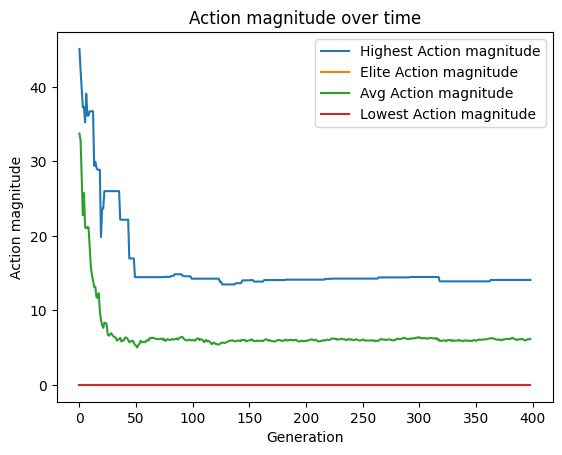

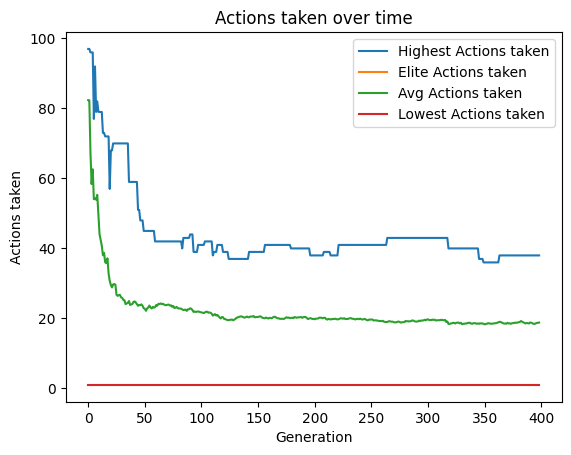

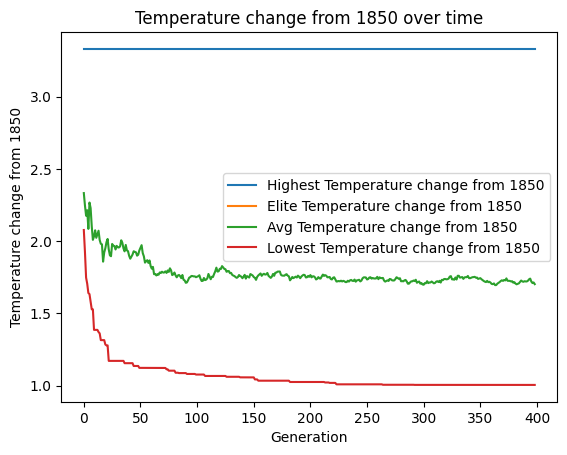

In [181]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(1, gens+1):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto.sort_values("distance", ascending=False)[outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.iloc[:n_elites].mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Highest {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Lowest {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

In [ ]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):

    gen_dfs = []
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df["color"] = gen
        gen_dfs.append(gen_df)
    
    total_gen_df = pd.concat(gen_dfs)
    cmap = "viridis_r" if len(gens) != 1 else "viridis"
    fig, ax = plt.subplots()
    scatter = ax.scatter(total_gen_df[outcome1], total_gen_df[outcome2], c=total_gen_df["color"], cmap=cmap)

    title = f"{outcome1} vs {outcome2} Final Pareto"

    if len(gens) != 1:
        cbar = fig.colorbar(scatter)
        cbar.set_label("Generation", rotation=270, labelpad=15)
        title = f"{outcome1} vs {outcome2} over Evolution"
    
    ax.set_title(title)

    ax.set_ylabel(outcome2)
    ax.set_xlabel(outcome1)
    plt.show()

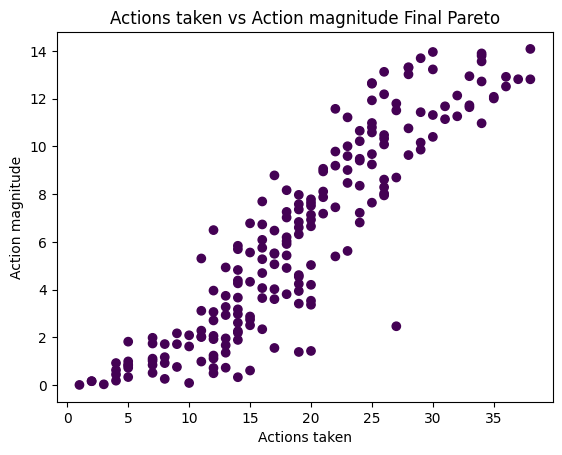

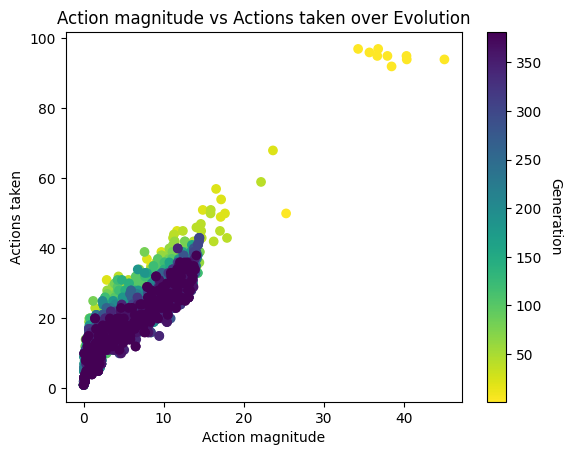

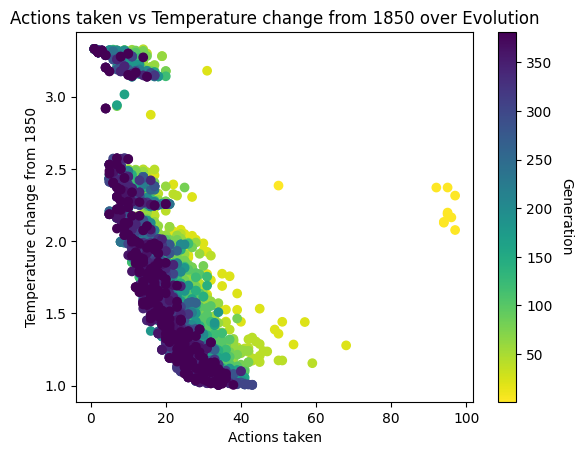

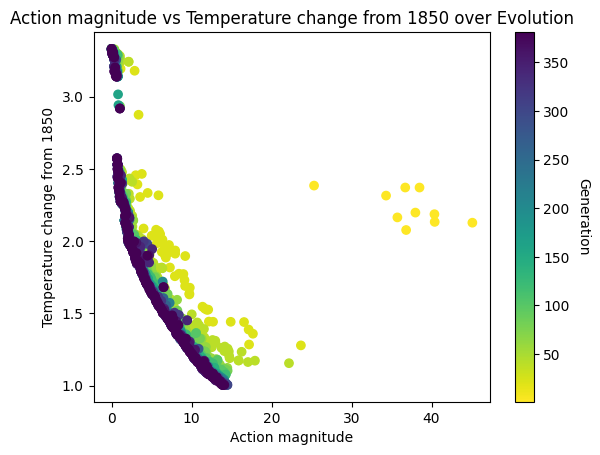

Bad pipe message: %s [b'_p\xf0\xee\xe9\x7fXF\x92X\x05\xef\x17\xf6\x04b7\xac\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0']
Bad pipe message: %s [b'\x7fnx\xabJ\xa0\xa6\xa9\xd3\xad^\xe4\xf4\xc3\xe6\xbb\xc7\x0e\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=']
Bad pipe messag

In [ ]:
plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[0], outcome_keys[1], range(1, gens+1, 20))
plot_two_objective(outcome_keys[1], outcome_keys[2], range(1, gens+1, 20))
plot_two_objective(outcome_keys[0], outcome_keys[2], range(1, gens+1, 20))

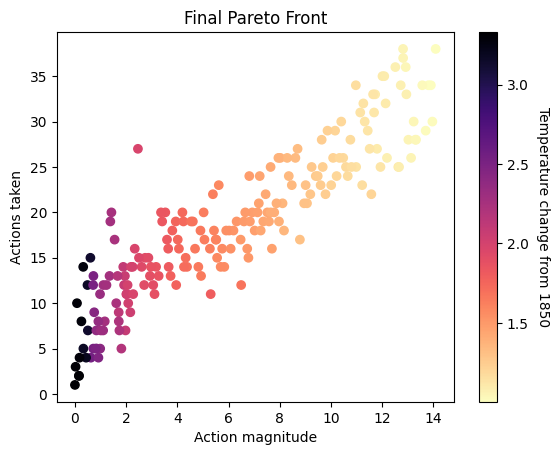

In [ ]:
def plot_three_objective(objs: list[str], gens: int):
    results_df = pd.read_csv(results_dir / f"{gens}.csv")
    results_df = results_df[results_df["rank"] == 1]
    fig, ax = plt.subplots()
    ax.set_xlabel(objs[0])
    ax.set_ylabel(objs[1])
    scatter = ax.scatter(results_df[objs[0]], results_df[objs[1]], c=results_df[objs[2]], cmap="magma_r")
    cbar = fig.colorbar(scatter)
    cbar.set_label(objs[2], rotation=270, labelpad=15)
    ax.set_title("Final Pareto Front")

    plt.show()

plot_three_objective([outcome_keys[0], outcome_keys[1], outcome_keys[2]], gens)
if len(outcome_keys) > 3:
    plot_three_objective([outcome_keys[0], outcome_keys[1], outcome_keys[3]], gens)

In [ ]:
from matplotlib.colors import hsv_to_rgb

def convert_to_hex(r, g, b):
    return "#{:02X}{:02X}{:02X}".format(int(r), int(g), int(b))

def plot_four_objective(objs: list[str], gens: int):
    results_df = pd.read_csv(results_dir / f"{gens}.csv")
    results_df = results_df[results_df["rank"] == 1]
    fig, ax = plt.subplots()
    ax.set_xlabel(objs[0])
    ax.set_ylabel(objs[1])

    # Add red to the color when objs[2] is high, add blue to the color when objs[3] is high. Purple for both
    r_min, r_max = results_df[objs[2]].min(), results_df[objs[2]].max()
    r_values = (results_df[objs[2]] - r_min) / (r_max - r_min)
    # r_values = 1 - r_values
    r_values = (r_values * 255).astype(int)
    
    b_min, b_max = results_df[objs[3]].min(), results_df[objs[3]].max()
    b_values = (results_df[objs[3]] - b_min) / (b_max - b_min)
    # b_values = 1 - b_values
    b_values = (b_values * 255).astype(int)

    color_col = [convert_to_hex(r, 0, b) for r, b in zip(r_values, b_values)]

    scatter = ax.scatter(results_df[objs[0]], results_df[objs[1]], c=color_col)
    plt.show()

if len(outcome_keys) > 3:
    plot_four_objective([outcome_keys[0], outcome_keys[1], outcome_keys[2], outcome_keys[3]], gens)

In [ ]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

Action magnitude                    0.0
Actions taken                       1.0
Temperature change from 1850    3.32968
Name: 0, dtype: object

Action magnitude                    0.0
Actions taken                       1.0
Temperature change from 1850    3.32968
Name: 0, dtype: object

Action magnitude                14.089479
Actions taken                        38.0
Temperature change from 1850      1.00404
Name: 1, dtype: object



['1_2', '364_172']

     cand_id                 parents  rank  distance  \
0        1_2                     NaN     1       inf   
2     396_75   ['395_155', '389_11']     1       inf   
32   381_147  ['376_196', '281_178']     1  0.045013   
34   261_106    ['222_97', '211_84']     1  0.044873   
67   399_181  ['379_198', '395_118']     1  0.037149   
68   163_147       ['115_49', '1_2']     1  0.036376   
80   369_115   ['367_47', '295_177']     1  0.024235   
121  367_117   ['295_177', '349_95']     1  0.017403   
141  378_179   ['370_168', '350_97']     1  0.016022   

     Temperature change from 1850  Actions taken  Action magnitude  
0                         3.32968            1.0      9.536743e-09  
2                         1.05754           38.0      1.281569e+01  
32                        1.17614           24.0      1.065537e+01  
34                        3.29687           10.0      8.036645e-02  
67                        1.24920           28.0      9.637709e+00  
68                       

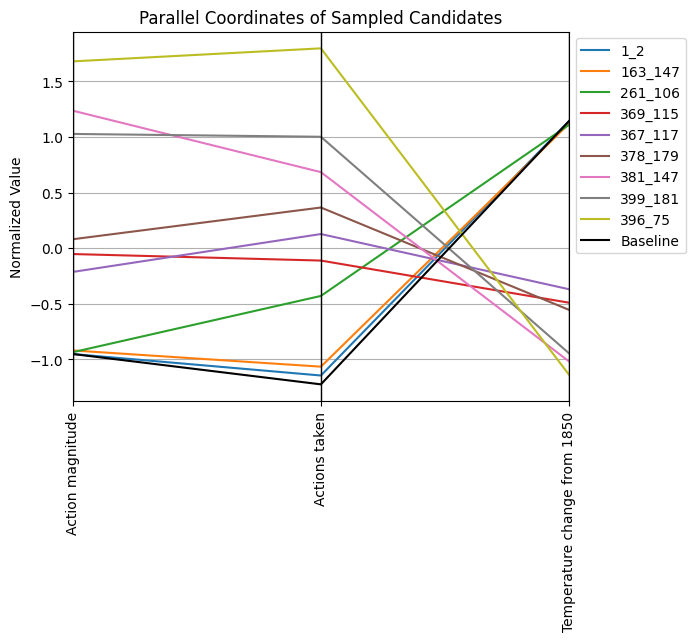

In [ ]:
def plot_parallel_coordinates(cand_ids):
    coords_dicts = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        cand_dict = dict(zip(outcomes.keys(), cand_coords))
        cand_dict["cand_id"] = cand_id
        coords_dicts.append(cand_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    colors[len(coords_df)-1] = "black" 
    pd.plotting.parallel_coordinates(normalized_df, "cand_id", color=colors)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

plot_parallel_coordinates(sample_points)
print(final_pareto[final_pareto["cand_id"].isin(sample_points)])

In [ ]:
def get_average_df(dfs: list[pd.DataFrame]):
    avg_df = dfs[0].copy()
    for df in dfs[1:]:
        avg_df += df
    avg_df /= len(dfs)
    return avg_df

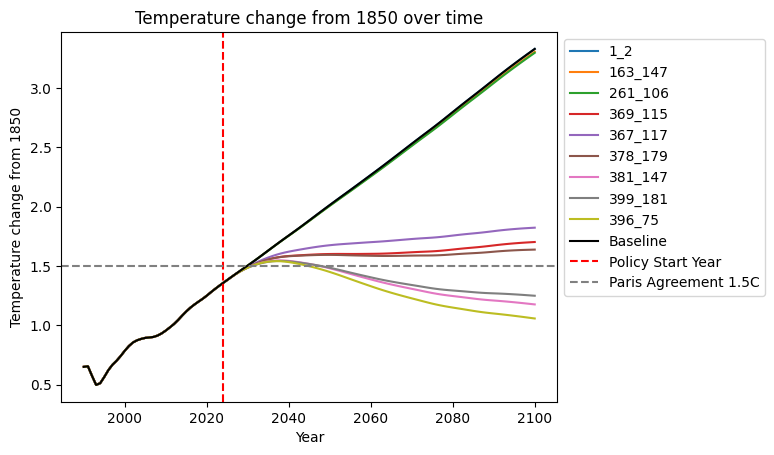

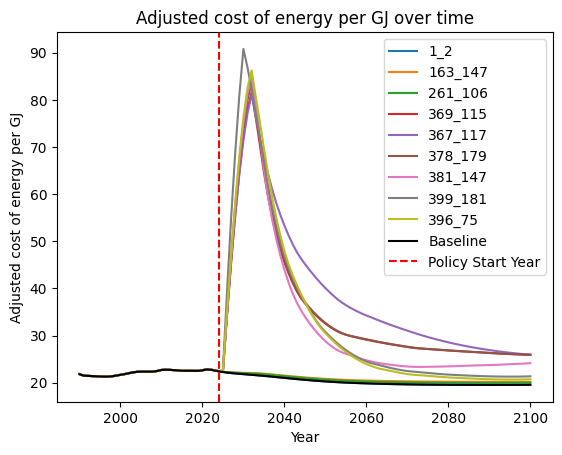

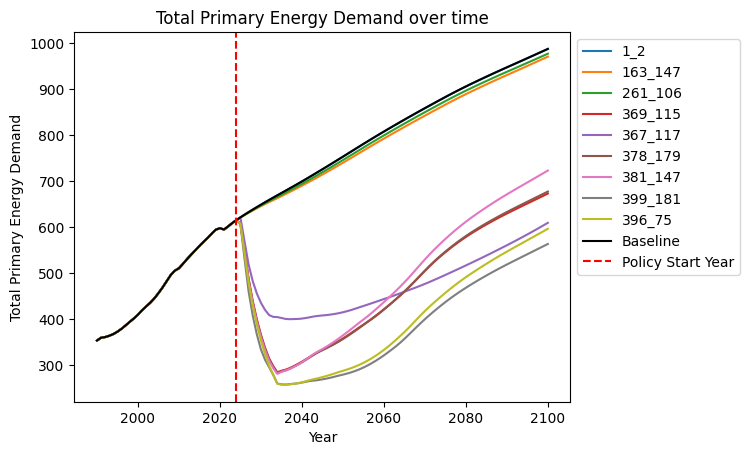

In [ ]:
def plot_outcome_over_time(outcome, cand_ids, paris=False):
    for cand_id in cand_ids:
        _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
        avg_df = get_average_df(cand_outcomes)
        plt.plot(range(1990, 2101), avg_df[outcome], label=f"{cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

    if outcome == "CO2 Equivalent Net Emissions":
        plt.axhline(y=0, color="gray", linestyle="--")
        if paris:
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

    elif outcome == "Temperature change from 1850":
        plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

    plt.legend(bbox_to_anchor=(1, 1))
    if len(cand_outcomes) > 1:
        plt.title(f"Average {outcome} over time over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

paris = "Emissions Above Paris Agreement" in outcomes
enroads_outcomes = ["Temperature change from 1850", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, sample_points, paris)

In [ ]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(7.5 * len(cand_ids), 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
            cand_outcomes = get_average_df(cand_outcomes)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    plt.show()

In [ ]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [f"Primary energy demand of {energy}" for energy in energies]

    _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
    avg_outcomes = get_average_df(cand_outcomes)
    energy_df = avg_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    if len(cand_outcomes) > 1:
        plt.title(f"Average Difference in Energy from Baseline for {cand_id} in 2100 over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

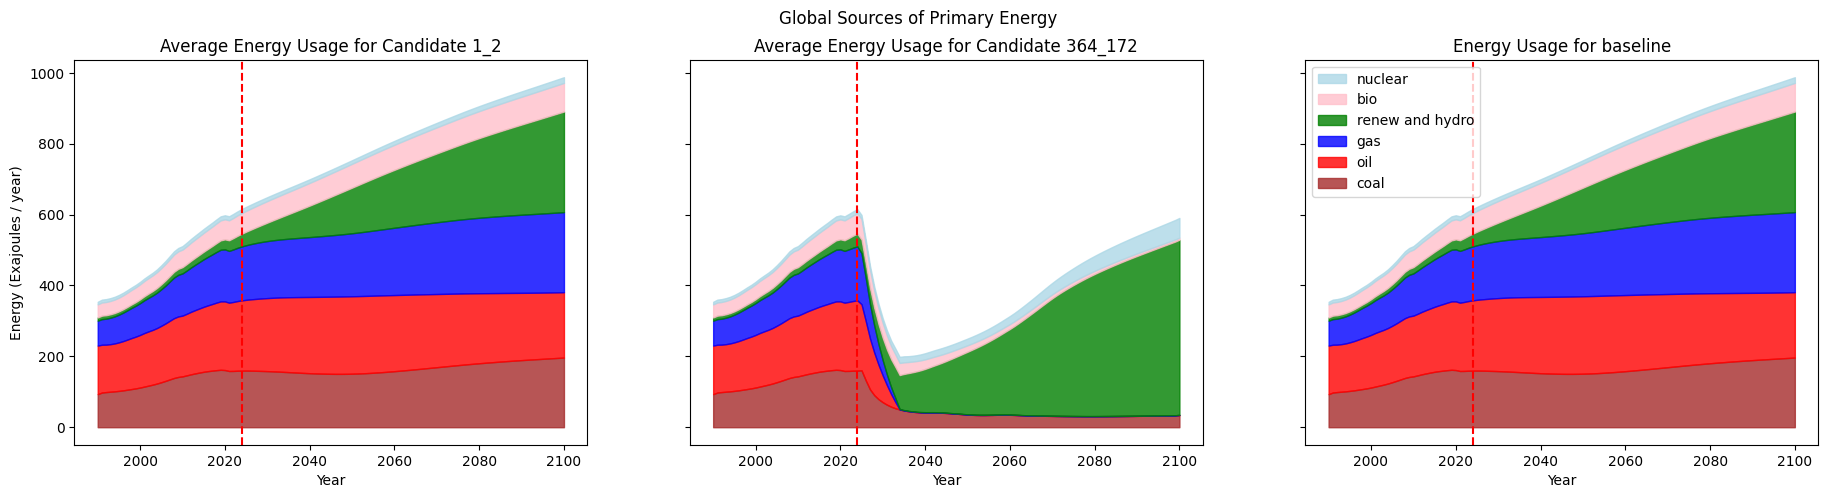

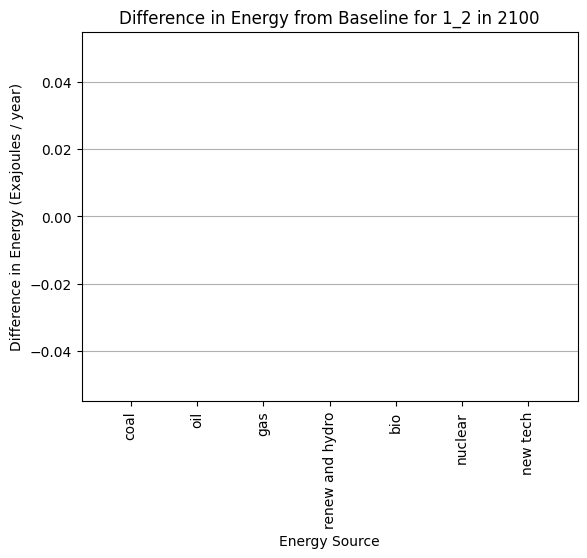

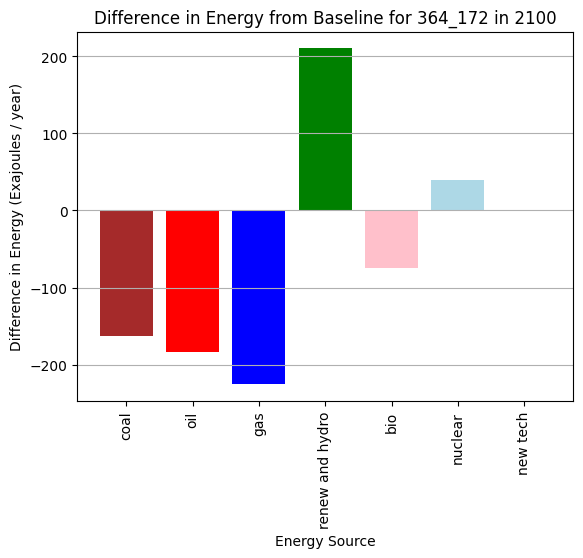

In [ ]:
examples = best_cand_ids
plot_energy_usage(examples +  ["baseline"])
plot_energy_difference(examples[0])
plot_energy_difference(examples[1])

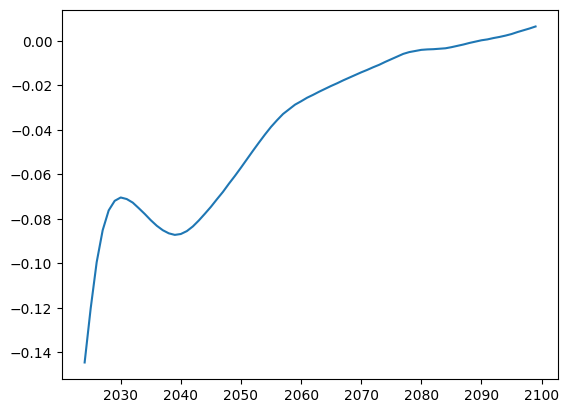

[-0.1444999999999972, -0.1203000000000003, -0.09950000000000259, -0.08509999999999707, -0.07620000000000005, -0.07190000000000296, -0.07039999999999935, -0.07109999999999772, -0.0727000000000011, -0.07519999999999882, -0.07779999999999987, -0.08060000000000045, -0.08310000000000173, -0.08510000000000062, -0.08649999999999736, -0.08720000000000283, -0.08680000000000021, -0.08549999999999969, -0.08339999999999748, -0.08070000000000022, -0.0777000000000001, -0.07460000000000022, -0.07120000000000104, -0.06789999999999807, -0.06420000000000314, -0.06069999999999709, -0.05700000000000216, -0.05320000000000036, -0.049399999999998556, -0.045700000000000074, -0.04210000000000136, -0.038699999999998624, -0.03569999999999851, -0.032900000000001484, -0.030799999999999272, -0.028700000000000614, -0.027200000000000557, -0.025600000000000733, -0.02430000000000021, -0.02289999999999992, -0.021599999999999397, -0.020299999999998875, -0.01910000000000167, -0.017799999999997596, -0.016600000000000392, -

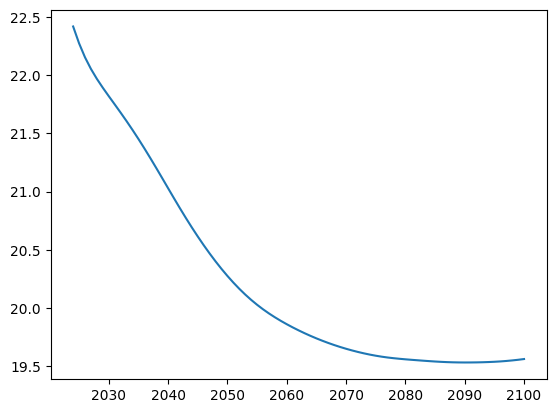

In [ ]:
def get_changes(cand_id):
    _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
    cost = cand_outcomes[0]["Adjusted cost of energy per GJ"].iloc[2024-1990:]
    change = cost.diff().shift(-1).dropna()
    plt.plot(range(2024, 2100), change)
    plt.show()

    print(change.tolist())
    print(cost.tolist())

    plt.plot(range(2024, 2101), cost)
    plt.show()

get_changes(examples[0])

In [ ]:
for example in examples:
    open_browser(results_dir, example, 0)

FileNotFoundError: [Errno 2] No such file or directory: 'results/all-action-direct-decomplexify/config.json'

Bad pipe message: %s [b'\t\x9c=\xdd\x92z\xd6\x1e\xc9\x82\xe7Z0\x07\xa6\xde\x1a\xdf\x00\x01|\x00\x00']
Bad pipe message: %s [b'\xf0\xf5m\x16P\xba\x11\xe0\xf5\xa6J\xb1\x12\xb2\x19\xd5\xb4&\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2']
Bad pipe message: %s [b'=\xf7s\xd0%\x8b\xab\xdf\xd5\xad\x9c\xde\xae\xe3\xea\x04*\x9f\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x

In [ ]:
print(len(actions))

115


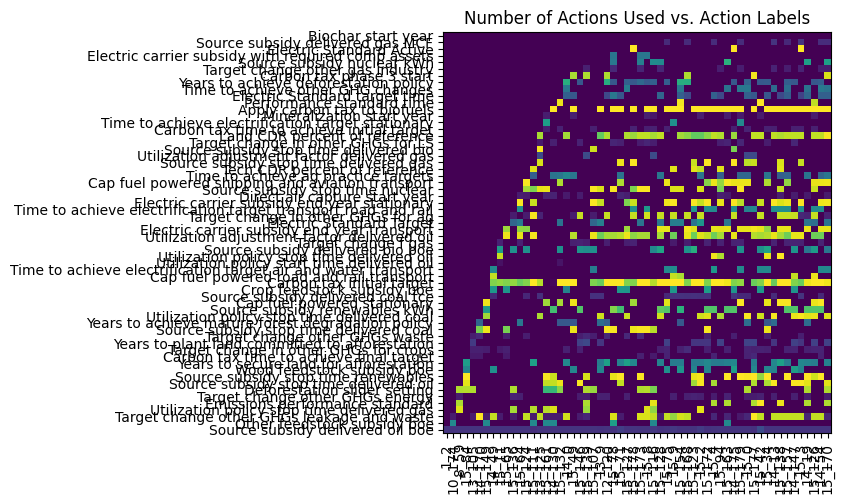

In [ ]:
from matplotlib.colors import ListedColormap
def get_actions_used(cand_ids):
    x_axis = []
    grid = []
    for cand_id in cand_ids:
        actions_used = np.zeros(len(actions))
        [cand_actions], _, _ = experimenter.get_candidate_results(cand_id)
        for action, val in cand_actions.items():
            row = input_specs[input_specs["varId"] == action].iloc[0]
            if row["defaultValue"] != val:
                if action not in x_axis:
                    x_axis.append(action)
                if row["kind"] == "slider":
                    normalized_val = (val - row["minValue"]) / (row["maxValue"] - row["minValue"])
                else:
                    normalized_val = 1 if val == row["onValue"] else 0
                actions_used[x_axis.index(action)] = normalized_val
        grid.append(actions_used)
    
    # Switch x axis labels to their nicer names
    for i, action in enumerate(x_axis):
        x_axis[i] = input_specs[input_specs["varId"] == action]["varName"].iloc[0]

    grid = np.stack(grid).T[:len(x_axis)]
    grid = np.flip(grid, axis=0)
    plt.figure(figsize=(5, 10))
    plt.yticks(range(len(x_axis)), reversed(x_axis))
    plt.xticks(range(len(cand_ids)), cand_ids, rotation=90)
    plt.title("Number of Actions Used vs. Action Labels")
    plt.imshow(grid, cmap="viridis")

if "Actions taken" in outcomes:
    cand_ids_by_actions = final_pareto.sort_values("Actions taken", ascending=True)["cand_id"].tolist()
    get_actions_used(cand_ids_by_actions)

In [ ]:
if "Actions taken" in outcomes:
    from experiments.heuristic import Heuristic
    heuristic = Heuristic(actions)
    actions_order, heuristic_dict = heuristic.find_heuristic()
    heuristic.plot_actions_used(actions_order, heuristic_dict)

make: `enroads' is up to date.


ValueError: Invalid EnroadsOutcome: CO2 Equivalent Net Emissions not in input specs

In [ ]:
heuristic.get_heuristic_urls(actions_order, heuristic_dict)

NameError: name 'heuristic' is not defined

In [ ]:
if "Actions taken" in outcomes:
    temp_actions_dict = {}
    carbons = []
    for i, action in enumerate(actions_order):
        temp_actions_dict[action] = heuristic_dict[action]
        outcome_df = evaluator.enroads_runner.evaluate_actions(temp_actions_dict)
        carbon = outcome_df["CO2 Equivalent Net Emissions"].iloc[-1]
        carbons.append(carbon)

    plt.xlabel("Actions Taken")
    plt.ylabel("CO2 Equivalent Net Emissions")
    plt.scatter(final_pareto["Actions taken"], final_pareto["CO2 Equivalent Net Emissions"], label="Trained Pareto")
    plt.scatter(range(1, len(actions_order)+1), carbons, label="Greedy Heuristic")
    plt.scatter([0], baseline_metrics["CO2 Equivalent Net Emissions"], label="Baseline", color="black")
    plt.axhline(y=0, color="gray", linestyle="--")
    plt.title("Pareto Front vs. Greedy Heuristic")
    plt.legend()
    plt.show()

NameError: name 'actions_order' is not defined